In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
from time import strftime, localtime
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from pandas import DataFrame
import seaborn as sn
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._9_rus_fft_angles import FNNCell,CNNCell

0
None
0
None
0


/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Классов: 76
None


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
TRACK_MAX_LEN=30
SHIFT_STEP=10
CURRENT_FOLDER="./"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data prepare

In [5]:
DATASET='russian_extra'# russian, russian_extra, uji
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_extra.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_extra.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print(len(list(TRAIN_DICT.keys())))
print(list(TRAIN_DICT.keys()).sort())
print(len(list(TEST_DICT.keys())))
print(list(TEST_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
    all_size+=len(TRAIN_DICT[key])
print(all_size)
all_size=0
for key in TEST_DICT.keys():
    all_size+=len(TEST_DICT[key])
print(all_size)

114
None
57
None
261
72


# NN prepare

In [7]:
# i=0
# module_list =[module for module in net.modules()]
# for count,val in enumerate(module_list):
#     print(i,count,val)
#     i+=1

In [8]:
NUM_CLASSES=76
DATASET_VARIANT="byclass"
net_fnn=FNNCell(track_max_len=TRACK_MAX_LEN,num_classes=NUM_CLASSES).to(device)
net_fnn.load_state_dict(torch.load("models/rus_fft_fcnet_"+DATASET_VARIANT+".pt"))        

<All keys matched successfully>

In [9]:
NUM_CLASSES=76
DATASET_VARIANT="byclass"
net_cnn=CNNCell(num_classes=NUM_CLASSES).to(device)
net_cnn.load_state_dict(torch.load("models/rus_fft_cnnnet_"+DATASET_VARIANT+".pt"))
net_cnn.eval()

CNNCell(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Conv1d(1, 20, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(20, 30, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(30, 40, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
 

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [11]:
net_fnn.fc1=Identity()
net_cnn.fc1=Identity()

# Process

In [12]:
# len(TRAIN_DICT["cъешь_w_0"][1].singlePolys().angles)

In [12]:
WORDS=set()
for k in TRAIN_DICT.keys():
    WORDS.add(k.split("_")[0])
len(WORDS),WORDS

(9,
 {'cъешь',
  'булок',
  'выпей',
  'да',
  'ещё',
  'мягких',
  'французских',
  'чаю',
  'этих'})

In [14]:
# WORDS=['cъешь','ещё','этих','мягких','французских','булок','да','выпей','чаю']

In [13]:
TRAIN_DICT_=dict()
for w in WORDS:
    if not w in TRAIN_DICT_:
        TRAIN_DICT_[w]=list()
    for k_trn in TRAIN_DICT.keys():
        if not k_trn.startswith(w): continue    
        TRAIN_DICT_[w]+=[c for c in TRAIN_DICT[k_trn]] 
TEST_DICT_=dict()
for w in WORDS:
    if not w in TEST_DICT_:
        TEST_DICT_[w]=list()
    for k_tst in TEST_DICT.keys():
        if not k_tst.startswith(w): continue    
        TEST_DICT_[w]+=[c for c in TEST_DICT[k_tst]] 

In [14]:
def getWriterList(ls,writer):
    ls_rez=np.array([])
    for w in ls:
        if int(str(w).split("_")[2])==writer:  
               ls_rez=np.append(ls_rez,w)
    if len(ls_rez)==0:
               ls_rez=np.append(ls_rez,None)
    return ls_rez

In [15]:
ls_train=np.array([])
for w in range(13):
    for w0 in getWriterList(TRAIN_DICT_['cъешь'],w):
        for w1 in getWriterList(TRAIN_DICT_['ещё'],w):
            for w2 in getWriterList(TRAIN_DICT_['этих'],w):
                for w3 in getWriterList(TRAIN_DICT_['мягких'],w):
                    for w4 in getWriterList(TRAIN_DICT_['французских'],w):
                        for w5 in getWriterList(TRAIN_DICT_['булок'],w):
                            for w6 in getWriterList(TRAIN_DICT_['да'],w):
                                for w7 in getWriterList(TRAIN_DICT_['выпей'],w):
                                    for w8 in getWriterList(TRAIN_DICT_['чаю'],w):
                                        # print(w0,w1,w2,w3,w4,w5,w6,w7,w8)
                                        ls_train=np.append(ls_train,[w,w0,w1,w2,w3,w4,w5,w6,w7,w8])
ls_train=ls_train.reshape(-1,10)    
ls_train.shape
np.random.shuffle(ls_train)
ls_train=ls_train[:100]

In [16]:
ls_test=np.array([])
for w in range(13):
    for w0 in getWriterList(TEST_DICT_['cъешь'],w):
        for w1 in getWriterList(TEST_DICT_['ещё'],w):
            for w2 in getWriterList(TEST_DICT_['этих'],w):
                for w3 in getWriterList(TEST_DICT_['мягких'],w):
                    for w4 in getWriterList(TEST_DICT_['французских'],w):
                        for w5 in getWriterList(TEST_DICT_['булок'],w):
                            for w6 in getWriterList(TEST_DICT_['да'],w):
                                for w7 in getWriterList(TEST_DICT_['выпей'],w):
                                    for w8 in getWriterList(TEST_DICT_['чаю'],w):
                                        # print(w0,w1,w2,w3,w4,w5,w6,w7,w8)
                                        ls_test=np.append(ls_test,[w,w0,w1,w2,w3,w4,w5,w6,w7,w8])
ls_test=ls_test.reshape(-1,10) 
ls_test.shape
np.random.shuffle(ls_test)

In [72]:
cos = torch.nn.CosineSimilarity(dim=1)

def calcFFT(ch,net,device,track_max_len=TRACK_MAX_LEN):
    yf = rfft(ch)
    F = np.abs(yf)[:track_max_len]
    F=torch.Tensor(F)
    vec=net(F[None,:].to(device))
    return vec

def compare_word(ch1,ch2,net,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP):
    # pass
    L=200
    N1=(len(ch1.singlePolys().angles)-L)//shift_step
    N2=(len(ch2.singlePolys().angles)-L)//shift_step
    N1=max(1,N1)
    N2=max(1,N2)
    sim_avg=0
    sim_num=0
    for i in range(N1):
        C1=ch1.singlePolys().angles[i*shift_step:i*shift_step+L]
        vec1=calcFFT(C1,net,device,track_max_len)
        sim_max=0
        for j in range(N2):
            C2=ch2.singlePolys().angles[j*shift_step:j*shift_step+L]
            vec2=calcFFT(C2,net,device,track_max_len)
            sim = cos(vec1, vec2)
            sim_max = max(float(sim),sim_max)
        sim_avg+=sim_max
        sim_num+=1
    sim_avg = 0 if sim_num==0 else sim_avg/sim_num
    return sim_avg

def process_all_phrase(net,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS):
    df=DataFrame()
    ph_a1=[]
    ph_a2=[]
    combination=1
    start_time = time.time()
    for tst in ls_test:
        for trn in ls_train:
            author1=tst[0]
            author2=trn[0]
            count=0
            sim_avg=0
            tst_arr=np.array([])
            trn_arr=np.array([])
            for i in range(1,10):
                if not (tst[i] is None) and not (trn[i] is None):
                    count+=1
                    tst_arr=np.append(tst_arr,tst[i])
                    trn_arr=np.append(trn_arr,trn[i])
                    sim_avg+=compare_word(tst[i],trn[i],net,device,track_max_len,shift_step)
            ph_a1.append(tst_arr)
            ph_a2.append(trn_arr)
            if count>0: sim_avg=sim_avg/count   
            new_row = {'Author1':author1, 'Author2':author2,  'Similarity':sim_avg,'One':1 if author1==author2 else 0}
            df = pd.concat([df, pd.DataFrame.from_records([new_row])])
            clear_output(True)
            t=(time.time()-start_time)/combination
            future_time=strftime('%Y-%m-%d %H:%M:%S', localtime(time.time()+(5700-combination)*t))
            print("N {}/5700  ({} sec/ph, arrival {}) -- Authors:({},{}) Similarity: {}".format(combination,round(t,1),future_time,author1,author2,sim_avg))
            # print("======")
            combination+=1
    print(combination)
    return df,ph_a1,ph_a2

In [73]:
df_cnn,ph_a1_cnn,ph_a2_cnn=process_all_phrase(net_cnn,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS)
df_cnn.to_excel('graphology_phraseCNN.xlsx')
df_cnn = pd.read_excel('graphology_phraseCNN.xlsx', index_col=0)

N 5700/5700  (3.3 sec/ph, arrival 2023-07-28 14:29:44) -- Authors:(11,0) Similarity: 0.577982136013704
5701


In [78]:
f_ph_a1_cnn= open(os.path.join(CURRENT_FOLDER,'ph_a1_cnn'), 'wb')
f_ph_a2_cnn= open(os.path.join(CURRENT_FOLDER,'ph_a2_cnn'), 'wb')
pickle.Pickler(f_ph_a1_cnn).dump(ph_a1_cnn)
pickle.Pickler(f_ph_a2_cnn).dump(ph_a2_cnn)
f_ph_a1_cnn.close()
f_ph_a2_cnn.close()

In [74]:
df_cnn.iloc()[6].values,ph_a1_cnn[6],ph_a2_cnn[6]

(array([1.      , 9.      , 0.561664, 0.      ]),
 array([cъешь_w_1_331, этих_w_1_185, французских_w_1_741, булок_w_1_343,
        да_w_1_173], dtype=object),
 array([cъешь_w_9_353, этих_w_9_206, французских_w_9_773, булок_w_9_352,
        да_w_9_234], dtype=object))

In [75]:
df_fnn,ph_a1_fnn,ph_a2_fnn=process_all_phrase(net_fnn,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS)
df_fnn.to_excel('graphology_phraseFNN.xlsx')
df_fnn = pd.read_excel('graphology_phraseFNN.xlsx', index_col=0)

N 5700/5700  (2.1 sec/ph, arrival 2023-07-28 17:46:04) -- Authors:(11,0) Similarity: 0.5094064354880419
5701


In [79]:
f_ph_a1_fnn= open(os.path.join(CURRENT_FOLDER,'ph_a1_fnn'), 'wb')
f_ph_a2_fnn= open(os.path.join(CURRENT_FOLDER,'ph_a2_fnn'), 'wb')
pickle.Pickler(f_ph_a1_fnn).dump(ph_a1_fnn)
pickle.Pickler(f_ph_a2_fnn).dump(ph_a2_fnn)
f_ph_a1_fnn.close()
f_ph_a2_fnn.close()

# Analyze

# FNN

In [17]:
df = pd.read_excel('graphology_phraseFNN.xlsx', index_col=0)

In [18]:
df_1=df.loc[df.One == 1]
df_0=df.loc[df.One == 0]

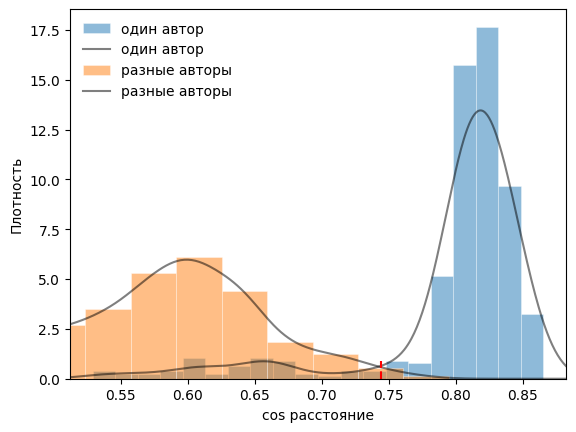

In [19]:
ax = df_1['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5,alpha=0.5)
xlim = ax.get_xlim()
ax=df_1['Similarity'].plot.density(color='k', alpha=0.5, ax=ax)
df_0['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', ax=ax, linewidth=0.5, alpha=0.5)
df_0['Similarity'].plot.density(color='k', alpha=0.5, ax=ax) 
ax.legend(["один автор","один автор","разные авторы","разные авторы"],frameon=False)
ax.plot([0.744,0.744],[0,0.9],color="r", linestyle='dashed')
ax.set_xlim(xlim)
plt.ylabel("Плотность")
plt.xlabel("cos расстояние")
plt.savefig("images/authors_phrase_fnn_disp.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [20]:
cm=np.zeros((2,2),dtype="int")
cm[0,0]=len(df_0.loc[(df_0.Similarity < 0.744)])
cm[0,1]=len(df_0.loc[(df_0.Similarity >= 0.744)])
cm[1,0]=len(df_1.loc[(df_1.Similarity < 0.744)])
cm[1,1]=len(df_1.loc[(df_1.Similarity >= 0.744)])
print(cm)

[[5178   61]
 [  47  414]]


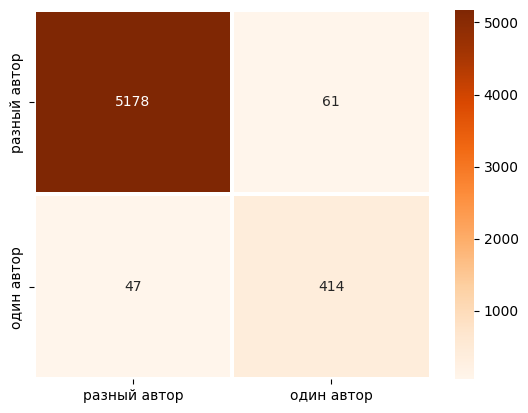

In [21]:
df_cm = DataFrame(cm, index=["разный автор","один автор"], columns=["разный автор","один автор"])
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/authors_phrase_fnn_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [22]:
TP = 414
TN = 5178
FP = 47
FN = 61
N=TP+TN+FP+FN
Accuracy=(TP+TN)/N    # общая точность
Precision=TP/(TP+FP)  # точность 
Recall=TP/(TP+FN)     # полнота
F1=2*Precision*Recall/(Precision+Recall)   # F1 мера
Sensitivity= TP / (TP + FN)
Specificity =TN / (TN + FP)
BalancedAccuracy=(Sensitivity+Specificity)/2
print("Accuracy: {}".format(Accuracy))
print("Precision: {}".format(Precision))
print("Recall: {}".format(Recall))
print("F1: {}".format(F1))
print("BalancedAccuracy: {}".format(BalancedAccuracy))

Accuracy: 0.9810526315789474
Precision: 0.8980477223427332
Recall: 0.871578947368421
F1: 0.8846153846153846
BalancedAccuracy: 0.9312918660287082


# CNN

In [119]:
df = pd.read_excel('graphology_phraseCNN.xlsx', index_col=0)

In [120]:
df_1=df.loc[df.One == 1]
df_0=df.loc[df.One == 0]

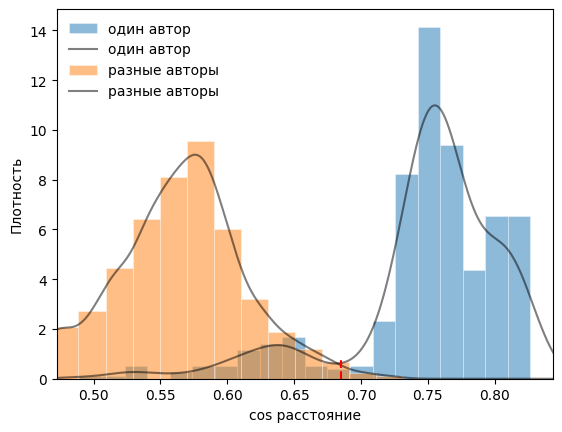

In [121]:
ax = df_1['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5,alpha=0.5)
xlim = ax.get_xlim()
ax=df_1['Similarity'].plot.density(color='k', alpha=0.5, ax=ax)
df_0['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', ax=ax, linewidth=0.5, alpha=0.5)
df_0['Similarity'].plot.density(color='k', alpha=0.5, ax=ax) 
ax.legend(["один автор","один автор","разные авторы","разные авторы"],frameon=False)
ax.plot([0.685,0.685],[0,0.8],color="r", linestyle='dashed')
ax.set_xlim(xlim)
plt.ylabel("Плотность")
plt.xlabel("cos расстояние")
plt.savefig("images/authors_phrase_cnn_disp.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [122]:
cm=np.zeros((2,2),dtype="int")
cm[0,0]=len(df_0.loc[(df_0.Similarity < 0.685)])
cm[0,1]=len(df_0.loc[(df_0.Similarity >= 0.685)])
cm[1,0]=len(df_1.loc[(df_1.Similarity < 0.685)])
cm[1,1]=len(df_1.loc[(df_1.Similarity >= 0.685)])
print(cm)

[[5186   53]
 [  55  406]]


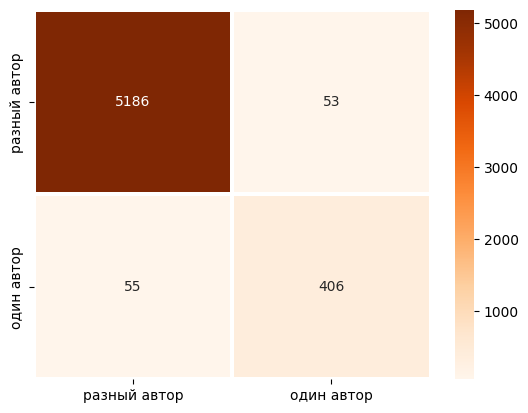

In [123]:
df_cm = DataFrame(cm, index=["разный автор","один автор"], columns=["разный автор","один автор"])
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/authors_phrase_cnn_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [124]:
TP = 406
TN = 5186
FP = 55
FN = 53
N=TP+TN+FP+FN
Accuracy=(TP+TN)/N    # общая точность
Precision=TP/(TP+FP)  # точность 
Recall=TP/(TP+FN)     # полнота
F1=2*Precision*Recall/(Precision+Recall)   # F1 мера
Sensitivity= TP / (TP + FN)
Specificity =TN / (TN + FP)
BalancedAccuracy=(Sensitivity+Specificity)/2
print("Accuracy: {}".format(Accuracy))
print("Precision: {}".format(Precision))
print("Recall: {}".format(Recall))
print("F1: {}".format(F1))
print("BalancedAccuracy: {}".format(BalancedAccuracy))

Accuracy: 0.9810526315789474
Precision: 0.8806941431670282
Recall: 0.8845315904139434
F1: 0.8826086956521738
BalancedAccuracy: 0.9370187049570193


# Количество/распределение слов в фразе

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5]),
 <BarContainer object of 10 artists>)

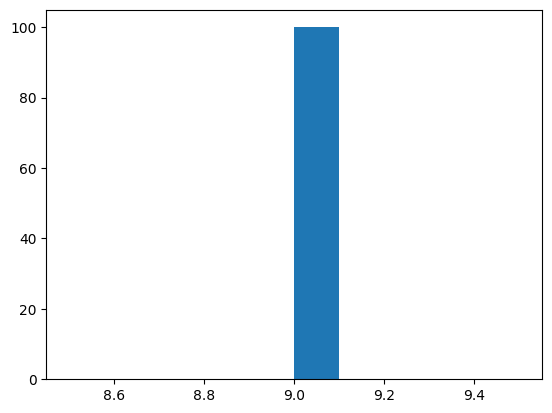

In [101]:
ls_train_=np.array([])
for ph in ls_train:
    ls_train_=np.append(ls_train_,sum(ph[1:]!=None))
plt.hist(ls_train_)

(array([ 1.,  0.,  3.,  0.,  4., 47.,  0.,  0.,  0.,  2.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

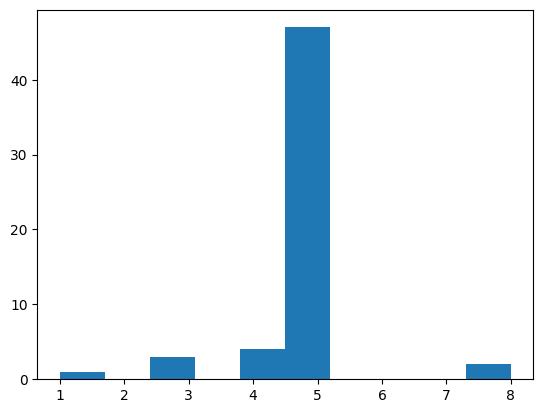

In [102]:
ls_test_=np.array([])
for ph in ls_test:
    ls_test_=np.append(ls_test_,sum(ph[1:]!=None))
plt.hist(ls_test_)

# Образцы фраз

In [24]:
df_fnn = pd.read_excel('graphology_phraseFNN.xlsx', index_col=0)
f_ph_a1_fnn= open(os.path.join(CURRENT_FOLDER,'ph_a1_fnn'), 'rb')
f_ph_a2_fnn= open(os.path.join(CURRENT_FOLDER,'ph_a2_fnn'), 'rb')
ph_a1_fnn = CustomUnpickler(f_ph_a1_fnn).load()
ph_a2_fnn = CustomUnpickler(f_ph_a2_fnn).load()
f_ph_a1_fnn.close()
f_ph_a2_fnn.close()        

In [25]:
idx=[i for i in range(5700)]
df_fnn.insert(0, "Idx", idx, True)
df_fnn.set_index("Idx")


,Author1,Author2,Similarity,One
Idx,,,,
0,1,8,0.675540,0
1,1,9,0.693115,0
2,1,2,0.438430,0
3,1,6,0.575448,0
4,1,4,0.474826,0
...,...,...,...,...
5695,11,4,0.513940,0
5696,11,9,0.587339,0
5697,11,3,0.496104,0


In [26]:
df_fnn

,Idx,Author1,Author2,Similarity,One
0,0,1,8,0.675540,0
0,1,1,9,0.693115,0
0,2,1,2,0.438430,0
0,3,1,6,0.575448,0
0,4,1,4,0.474826,0
...,...,...,...,...,...
0,5695,11,4,0.513940,0
0,5696,11,9,0.587339,0
0,5697,11,3,0.496104,0
0,5698,11,8,0.646331,0


In [27]:
def plot_curve2(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    for poly in char.polys:
      for i in range(0,len(poly.points)):
        if i==len(poly.points)-1:
          break
        x_=[]
        y_=[]  
        x_.append(poly.points[i].x)
        x_.append(poly.points[i+1].x)
        y_.append(poly.points[i].y)
        y_.append(poly.points[i+1].y)
        len_=math.sqrt((x_[1]-x_[0])**2+(y_[1]-y_[0])**2)
        ax.plot( x_ ,y_,linewidth=5,color=str(3*len_/255.))

In [28]:
df_fnn.iloc[401]

Idx           401.000000
Author1         8.000000
Author2         9.000000
Similarity      0.711851
One             0.000000
Name: 0, dtype: float64

In [29]:
ph_a1_fnn[401],ph_a2_fnn[401]

(array([cъешь_w_8_421, этих_w_8_313, мягких_w_8_489, французских_w_8_944,
        выпей_w_8_442], dtype=object),
 array([cъешь_w_9_339, этих_w_9_207, мягких_w_9_331, французских_w_9_773,
        выпей_w_9_352], dtype=object))

In [30]:
import math

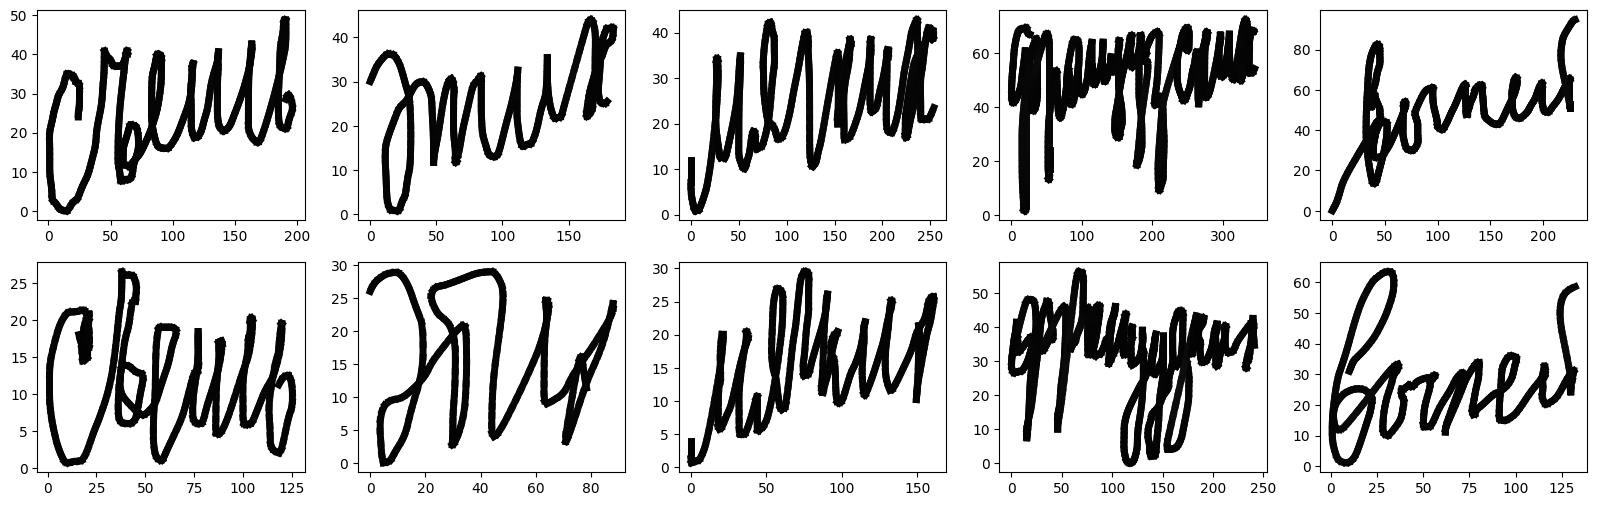

In [31]:
fig = plt.figure(figsize = (20,6))
ax0 = fig.add_subplot(2,5,1)
ax1 = fig.add_subplot(2,5,2)
ax2 = fig.add_subplot(2,5,3)
ax3 = fig.add_subplot(2,5,4)
ax4 = fig.add_subplot(2,5,5)
ax10 = fig.add_subplot(2,5,6)
ax11 = fig.add_subplot(2,5,7)
ax12 = fig.add_subplot(2,5,8)
ax13 = fig.add_subplot(2,5,9)
ax14 = fig.add_subplot(2,5,10)
plot_curve2(plt,ax0,ph_a1_fnn[401][0])
plot_curve2(plt,ax1,ph_a1_fnn[401][1])
plot_curve2(plt,ax2,ph_a1_fnn[401][2])
plot_curve2(plt,ax3,ph_a1_fnn[401][3])
plot_curve2(plt,ax4,ph_a1_fnn[401][4])
plot_curve2(plt,ax10,ph_a2_fnn[401][0])
plot_curve2(plt,ax11,ph_a2_fnn[401][1])
plot_curve2(plt,ax12,ph_a2_fnn[401][2])
plot_curve2(plt,ax13,ph_a2_fnn[401][3])
plot_curve2(plt,ax14,ph_a2_fnn[401][4])
plt.savefig("images/different_authors_phrases.png",  bbox_inches='tight', pad_inches=0)

In [32]:
df_fnn.iloc[400]

Idx           400.000000
Author1         8.000000
Author2         8.000000
Similarity      0.801352
One             1.000000
Name: 0, dtype: float64

In [33]:
ph_a1_fnn[400],ph_a2_fnn[400]

(array([cъешь_w_8_421, этих_w_8_313, мягких_w_8_489, французских_w_8_944,
        выпей_w_8_442], dtype=object),
 array([cъешь_w_8_362, этих_w_8_354, мягких_w_8_503, французских_w_8_940,
        выпей_w_8_384], dtype=object))

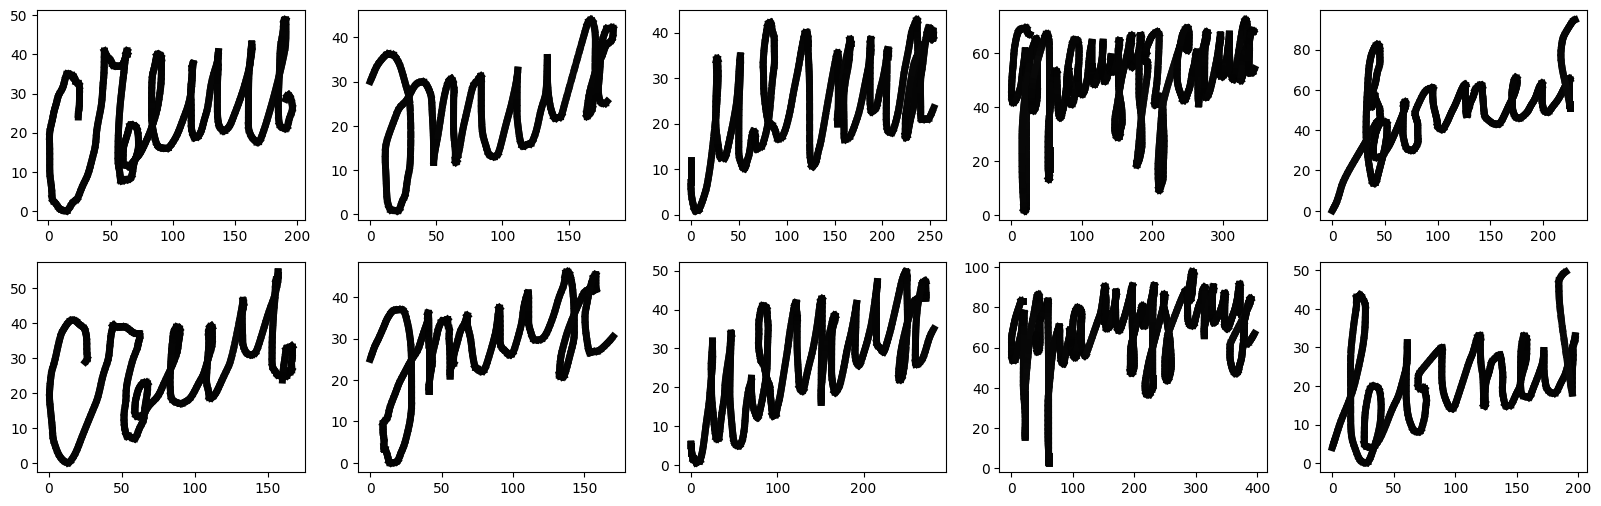

In [34]:
fig = plt.figure(figsize = (20,6))
ax0 = fig.add_subplot(2,5,1)
ax1 = fig.add_subplot(2,5,2)
ax2 = fig.add_subplot(2,5,3)
ax3 = fig.add_subplot(2,5,4)
ax4 = fig.add_subplot(2,5,5)
ax10 = fig.add_subplot(2,5,6)
ax11 = fig.add_subplot(2,5,7)
ax12 = fig.add_subplot(2,5,8)
ax13 = fig.add_subplot(2,5,9)
ax14 = fig.add_subplot(2,5,10)
plot_curve2(plt,ax0,ph_a1_fnn[400][0])
plot_curve2(plt,ax1,ph_a1_fnn[400][1])
plot_curve2(plt,ax2,ph_a1_fnn[400][2])
plot_curve2(plt,ax3,ph_a1_fnn[400][3])
plot_curve2(plt,ax4,ph_a1_fnn[400][4])
plot_curve2(plt,ax10,ph_a2_fnn[400][0])
plot_curve2(plt,ax11,ph_a2_fnn[400][1])
plot_curve2(plt,ax12,ph_a2_fnn[400][2])
plot_curve2(plt,ax13,ph_a2_fnn[400][3])
plot_curve2(plt,ax14,ph_a2_fnn[400][4])
plt.savefig("images/one_authors_phrases.png",  bbox_inches='tight', pad_inches=0)